In [49]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import csv
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [50]:
#Loads in the dataset
df = pd.read_parquet("merged_nominal.parquet")

#Loads in the process names
with open("summary.json", "r") as f:
  proc_dict = json.load(f)["sample_id_map"]

In [51]:
#Creates the background and signal datasets.
background = pd.concat((df[df.process_id == proc_dict["DiPhoton"]],df[df.process_id == proc_dict["TTGG"]],df[df.process_id == proc_dict["TTGamma"]],
                        df[df.process_id == proc_dict["TTJets"]],df[df.process_id == proc_dict["VBFH_M125"]],df[df.process_id == proc_dict["WGamma"]],
                        df[df.process_id == proc_dict["ZGamma"]],df[df.process_id == proc_dict["ggH_M125"]],df[df.process_id == proc_dict["ttH_M125"]],
                        df[df.process_id == proc_dict["GJets"]]), ignore_index=True, axis=0)
signal = df[df.process_id == proc_dict["GluGluToRadionToHHTo2G2Tau_M-300"]]

In [52]:
signal

,Diphoton_mass,Diphoton_pt_mgg,Diphoton_dPhi,LeadPhoton_pt_mgg,SubleadPhoton_pt_mgg,MET_pt,diphoton_met_dPhi,ditau_met_dPhi,ditau_deta,lead_lepton_pt,...,weight_photon_id_sf_Diphoton_Photon_down,weight_btag_deepjet_sf_SelectedJet_up_lf,weight_muon_id_sfSTAT_SelectedMuon_central,weight_muon_iso_sfSTAT_SelectedMuon_up,weight_central_no_lumi,weight_btag_deepjet_sf_SelectedJet_up_cferr2,weight_btag_deepjet_sf_SelectedJet_up_lfstats2,weight_muon_iso_sfSYS_SelectedMuon_up,weight_tau_idDeepTauVSjet_sf_AnalysisTau_central,weight_L1_prefiring_sf_central
1314751,124.780365,0.551937,1.805603,0.521988,0.338033,27.473833,1.215388,1.579931,0.031067,50.522717,...,0.963116,0.958278,1.000000,1.000000,0.000015,0.949245,0.980483,1.000000,0.813810,1.0
1314752,122.565300,0.133060,-3.080549,0.529156,0.399086,7.945946,-1.893136,-9.000000,-9.000000,31.647694,...,0.949265,0.958278,1.000000,1.000000,0.000016,0.949245,0.980483,1.000000,0.951858,1.0
1314753,124.521172,0.840922,-1.324463,0.551521,0.514404,71.722595,3.085998,0.153474,-1.053726,36.084164,...,0.937388,1.022507,1.000000,1.000000,0.000019,1.012869,1.025575,1.000000,0.938248,1.0
1314754,126.159004,1.087142,1.139099,0.671400,0.619086,15.152800,-2.570270,-1.302164,0.920532,48.846729,...,0.960828,0.958278,1.000000,1.000000,0.000017,0.949245,0.980483,1.000000,0.867371,1.0
1314755,123.189789,0.470546,2.366455,0.665731,0.409504,22.815020,1.895455,-9.000000,-9.000000,23.919144,...,0.964009,1.050011,1.000000,1.000000,0.000021,1.040113,1.049324,1.000000,0.937022,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381723,120.927391,0.634448,2.013977,0.689963,0.414240,47.427219,-3.140318,-0.219545,0.781128,39.041534,...,0.974851,0.894282,1.000000,1.000000,0.000009,0.884743,0.895361,1.000000,1.000000,1.0
1381724,125.184685,0.760199,2.083478,0.869319,0.363040,55.504910,2.551354,0.257433,-0.208740,55.370079,...,0.986287,0.966013,1.000000,1.000000,0.000009,0.955710,0.983569,1.000000,0.932038,1.0
1381725,124.841972,0.494437,-2.194267,0.597091,0.445994,84.648338,2.694745,-9.000000,-9.000000,24.640579,...,0.941830,0.966013,1.000000,1.000000,0.000008,0.955710,0.983569,1.000000,0.883856,1.0
1381726,123.824524,0.187350,2.765503,0.507824,0.489982,66.311852,-2.600566,-0.362751,0.129883,35.894508,...,0.944910,0.966013,0.993151,1.012405,0.000008,0.955710,0.983569,1.013847,1.000000,1.0


In [53]:

# added 'ditau_met_dPhi','ditau_deta' ,'Diphoton_sublead_lepton_deta','Diphoton_ditau_deta', 'ditau_mass'
background_subset = background[['reco_MX_mgg', 'Diphoton_pt_mgg', 'LeadPhoton_pt_mgg','ditau_pt', 'Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR',
                                'SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta', 'ditau_met_dPhi','ditau_deta' ,'Diphoton_sublead_lepton_deta',
                                'Diphoton_ditau_deta', 'ditau_mass','weight_central']]
signal_subset = signal[['reco_MX_mgg', 'Diphoton_pt_mgg', 'LeadPhoton_pt_mgg','ditau_pt', 'Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR',
                        'SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','ditau_met_dPhi','ditau_deta' ,'Diphoton_sublead_lepton_deta',
                        'Diphoton_ditau_deta', 'ditau_mass','weight_central']]

In [54]:
background_subset = background_subset.loc[(background_subset['reco_MX_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['Diphoton_pt_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['LeadPhoton_pt_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['ditau_pt'] >= 0)]
background_subset = background_subset.loc[(background_subset['Diphoton_dPhi'] >= -4)]
background_subset = background_subset.loc[(background_subset['dilep_leadpho_mass'] >= 0)]
background_subset = background_subset.loc[(background_subset['lead_lepton_pt'] >= 0)]
background_subset = background_subset.loc[(background_subset['MET_pt'] >= 0)]
background_subset = background_subset.loc[(background_subset['ditau_dR'] >= 0)]
background_subset = background_subset.loc[(background_subset['SubleadPhoton_pt_mgg'] >= 0)]
background_subset = background_subset.loc[(background_subset['Diphoton_lead_lepton_deta'] >= -7)]
background_subset = background_subset.loc[(background_subset['ditau_met_dPhi'] >= -3.2)]
background_subset = background_subset.loc[(background_subset['ditau_deta'] >= -5)]
background_subset = background_subset.loc[(background_subset['Diphoton_sublead_lepton_deta'] >= -7)]
background_subset = background_subset.loc[(background_subset['Diphoton_ditau_deta'] >= -7)]
background_subset = background_subset.loc[(background_subset['ditau_mass'] >= 0)]

In [55]:
signal_subset = signal_subset.loc[(signal_subset['reco_MX_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_pt_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['LeadPhoton_pt_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['ditau_pt'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_dPhi'] >= -4)]
signal_subset = signal_subset.loc[(signal_subset['dilep_leadpho_mass'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['lead_lepton_pt'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['MET_pt'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['ditau_dR'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['SubleadPhoton_pt_mgg'] >= 0)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_lead_lepton_deta'] >= -7)]
signal_subset = signal_subset.loc[(signal_subset['ditau_met_dPhi'] >= -3.2)]
signal_subset = signal_subset.loc[(signal_subset['ditau_deta'] >= -5)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_sublead_lepton_deta'] >= -7)]
signal_subset = signal_subset.loc[(signal_subset['Diphoton_ditau_deta'] >= -7)]
signal_subset = signal_subset.loc[(signal_subset['ditau_mass'] >= 0)]

In [56]:
background_subset_y = pd.DataFrame(np.zeros(len(background_subset)))
signal_subset_y = pd.DataFrame(np.ones(len(signal_subset)))

In [57]:
x = pd.concat((signal_subset,background_subset), ignore_index=True, axis=0)
y = pd.concat((signal_subset_y,background_subset_y), ignore_index=True, axis=0)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [59]:
X_train['weight_central']

16947     0.000376
21915     0.000520
75689     0.000258
77496     0.067669
138928   -0.000248
            ...   
110268   -0.000114
119879    0.000100
103694    0.000134
131932    0.000194
121958    0.000103
Name: weight_central, Length: 101600, dtype: float32

In [60]:
X_train_weight = X_train['weight_central']
X_train.drop("weight_central", axis='columns', inplace=True)
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
x_train_weight = torch.tensor(X_train_weight.to_numpy(), dtype=torch.float32).reshape(-1, 1)

x_train_weight[y_train==0] *= (x_train_weight[y_train==1].sum() / x_train_weight[y_train==0].sum())

X_test_weight = X_test['weight_central']
X_test.drop("weight_central", axis='columns', inplace=True)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)
x_test_weight = torch.tensor(X_test_weight.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [61]:
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(16, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

In [62]:
model = SimpleClassifier()

In [63]:
def weightedBCELoss(input, target, weight):
  x, y, w = input, target, weight
  log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
  return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))

In [64]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
n_epochs = 10
batch_size = 1024

In [65]:
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size]
        loss = weightedBCELoss(y_pred, ybatch,x_train_weight[i:i+batch_size])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 9.033962123794481e-05
Finished epoch 1, latest loss 9.119370224652812e-05
Finished epoch 2, latest loss 8.609453652752563e-05
Finished epoch 3, latest loss 8.713336865184829e-05
Finished epoch 4, latest loss 8.711269765626639e-05
Finished epoch 5, latest loss 8.511002670275047e-05
Finished epoch 6, latest loss 8.666821668157354e-05
Finished epoch 7, latest loss 8.556330431019887e-05
Finished epoch 8, latest loss 8.437009091721848e-05
Finished epoch 9, latest loss 8.341910142917186e-05


In [66]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

In [67]:
y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.6916452050209045


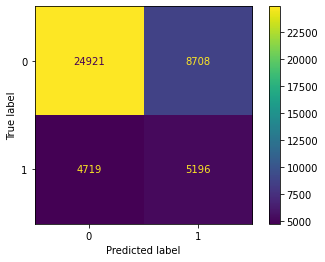

In [68]:
cm = confusion_matrix(y_test.detach().numpy(), y_pred.round().detach().numpy())
ConfusionMatrixDisplay(cm).plot()

In [ ]:
# plot of train/loss per epoch
# roc curves with the output score (include AUC)
# Hisotgram of output score 
# Play around with the nn